---
title: Practice_Activity_9.2 Multiclass
author: Sneha Narayanan
format:
    html:
        toc: true
        code-fold: true
embed-resources: true
theme: "Lumen"

---


Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

In [2]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

In [36]:
ha.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


In [64]:
X = ha.drop(columns=["cp"])
y = ha["cp"]

In [65]:
X["output"] = ha["output"]

In [66]:
categorical_cols = ["sex", "restecg"]
numerical_cols = ["age", "trtbps", "chol", "thalach"]

In [67]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat", OneHotEncoder(), categorical_cols + ["output"])  # Include 'output' as categorical
    ]
)

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [69]:
pipelines = {
    "KNN": Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", KNeighborsClassifier())
    ]),
    "DecisionTree": Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", DecisionTreeClassifier(random_state=42))
    ]),
    "LDA": Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", LinearDiscriminantAnalysis())
    ])
}

In [70]:
param_grids = {
    "KNN": {
        "classifier__n_neighbors": [3, 5, 7],
        "classifier__weights": ["uniform", "distance"]
    },
    "DecisionTree": {
        "classifier__max_depth": [3, 5, 7, None],
        "classifier__criterion": ["gini", "entropy"]
    },
    "LDA": {}
}

In [71]:
results = {}
for name, pipeline in pipelines.items():
    grid_search = GridSearchCV(
        pipeline, 
        param_grid=param_grids[name], 
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring="accuracy",
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    results[name] = {
        "best_params": grid_search.best_params_,
        "accuracy": accuracy_score(y_test, y_pred),
        "classification_report": classification_report(y_test, y_pred)
    }

/Users/snehanarayanan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/snehanarayanan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/snehanarayanan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [72]:
print(f"--- {name} ---")
print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", results[name]["accuracy"])
print("Classification Report:\n", results[name]["classification_report"])

--- LDA ---
Best Parameters: {}
Accuracy: 0.4909090909090909
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.73      0.69        26
           1       0.20      0.22      0.21         9
           2       0.40      0.38      0.39        16
           3       0.00      0.00      0.00         4

    accuracy                           0.49        55
   macro avg       0.31      0.33      0.32        55
weighted avg       0.46      0.49      0.47        55



In [73]:
results = {}

for name, pipeline in pipelines.items():
    print(f"Running GridSearchCV for {name}...")
    
    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grids[name],  # Get param grid specific to the model
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring="accuracy",  # Optimize for accuracy
        n_jobs=-1  # Utilize multiple CPU cores
    )
    
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    results[name] = {
        "best_params": grid_search.best_params_,
        "accuracy": accuracy_score(y_test, y_pred),
        "classification_report": classification_report(y_test, y_pred, target_names=["asymptomatic", "typical angina", "atypical angina", "non-anginal pain"])
    }

for name, result in results.items():
    print(f"--- {name} ---")
    print("Best Parameters:", result["best_params"])
    print("Accuracy:", result["accuracy"])
    print("Classification Report:\n", result["classification_report"])

Running GridSearchCV for KNN...
Running GridSearchCV for DecisionTree...
Running GridSearchCV for LDA...
--- KNN ---
Best Parameters: {'classifier__n_neighbors': 7, 'classifier__weights': 'uniform'}
Accuracy: 0.45454545454545453
Classification Report:
                   precision    recall  f1-score   support

    asymptomatic       0.58      0.73      0.64        26
  typical angina       0.20      0.22      0.21         9
 atypical angina       0.36      0.25      0.30        16
non-anginal pain       0.00      0.00      0.00         4

        accuracy                           0.45        55
       macro avg       0.28      0.30      0.29        55
    weighted avg       0.41      0.45      0.43        55

--- DecisionTree ---
Best Parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 3}
Accuracy: 0.4909090909090909
Classification Report:
                   precision    recall  f1-score   support

    asymptomatic       0.62      0.69      0.65        26
  typic

/Users/snehanarayanan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/snehanarayanan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/snehanarayanan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

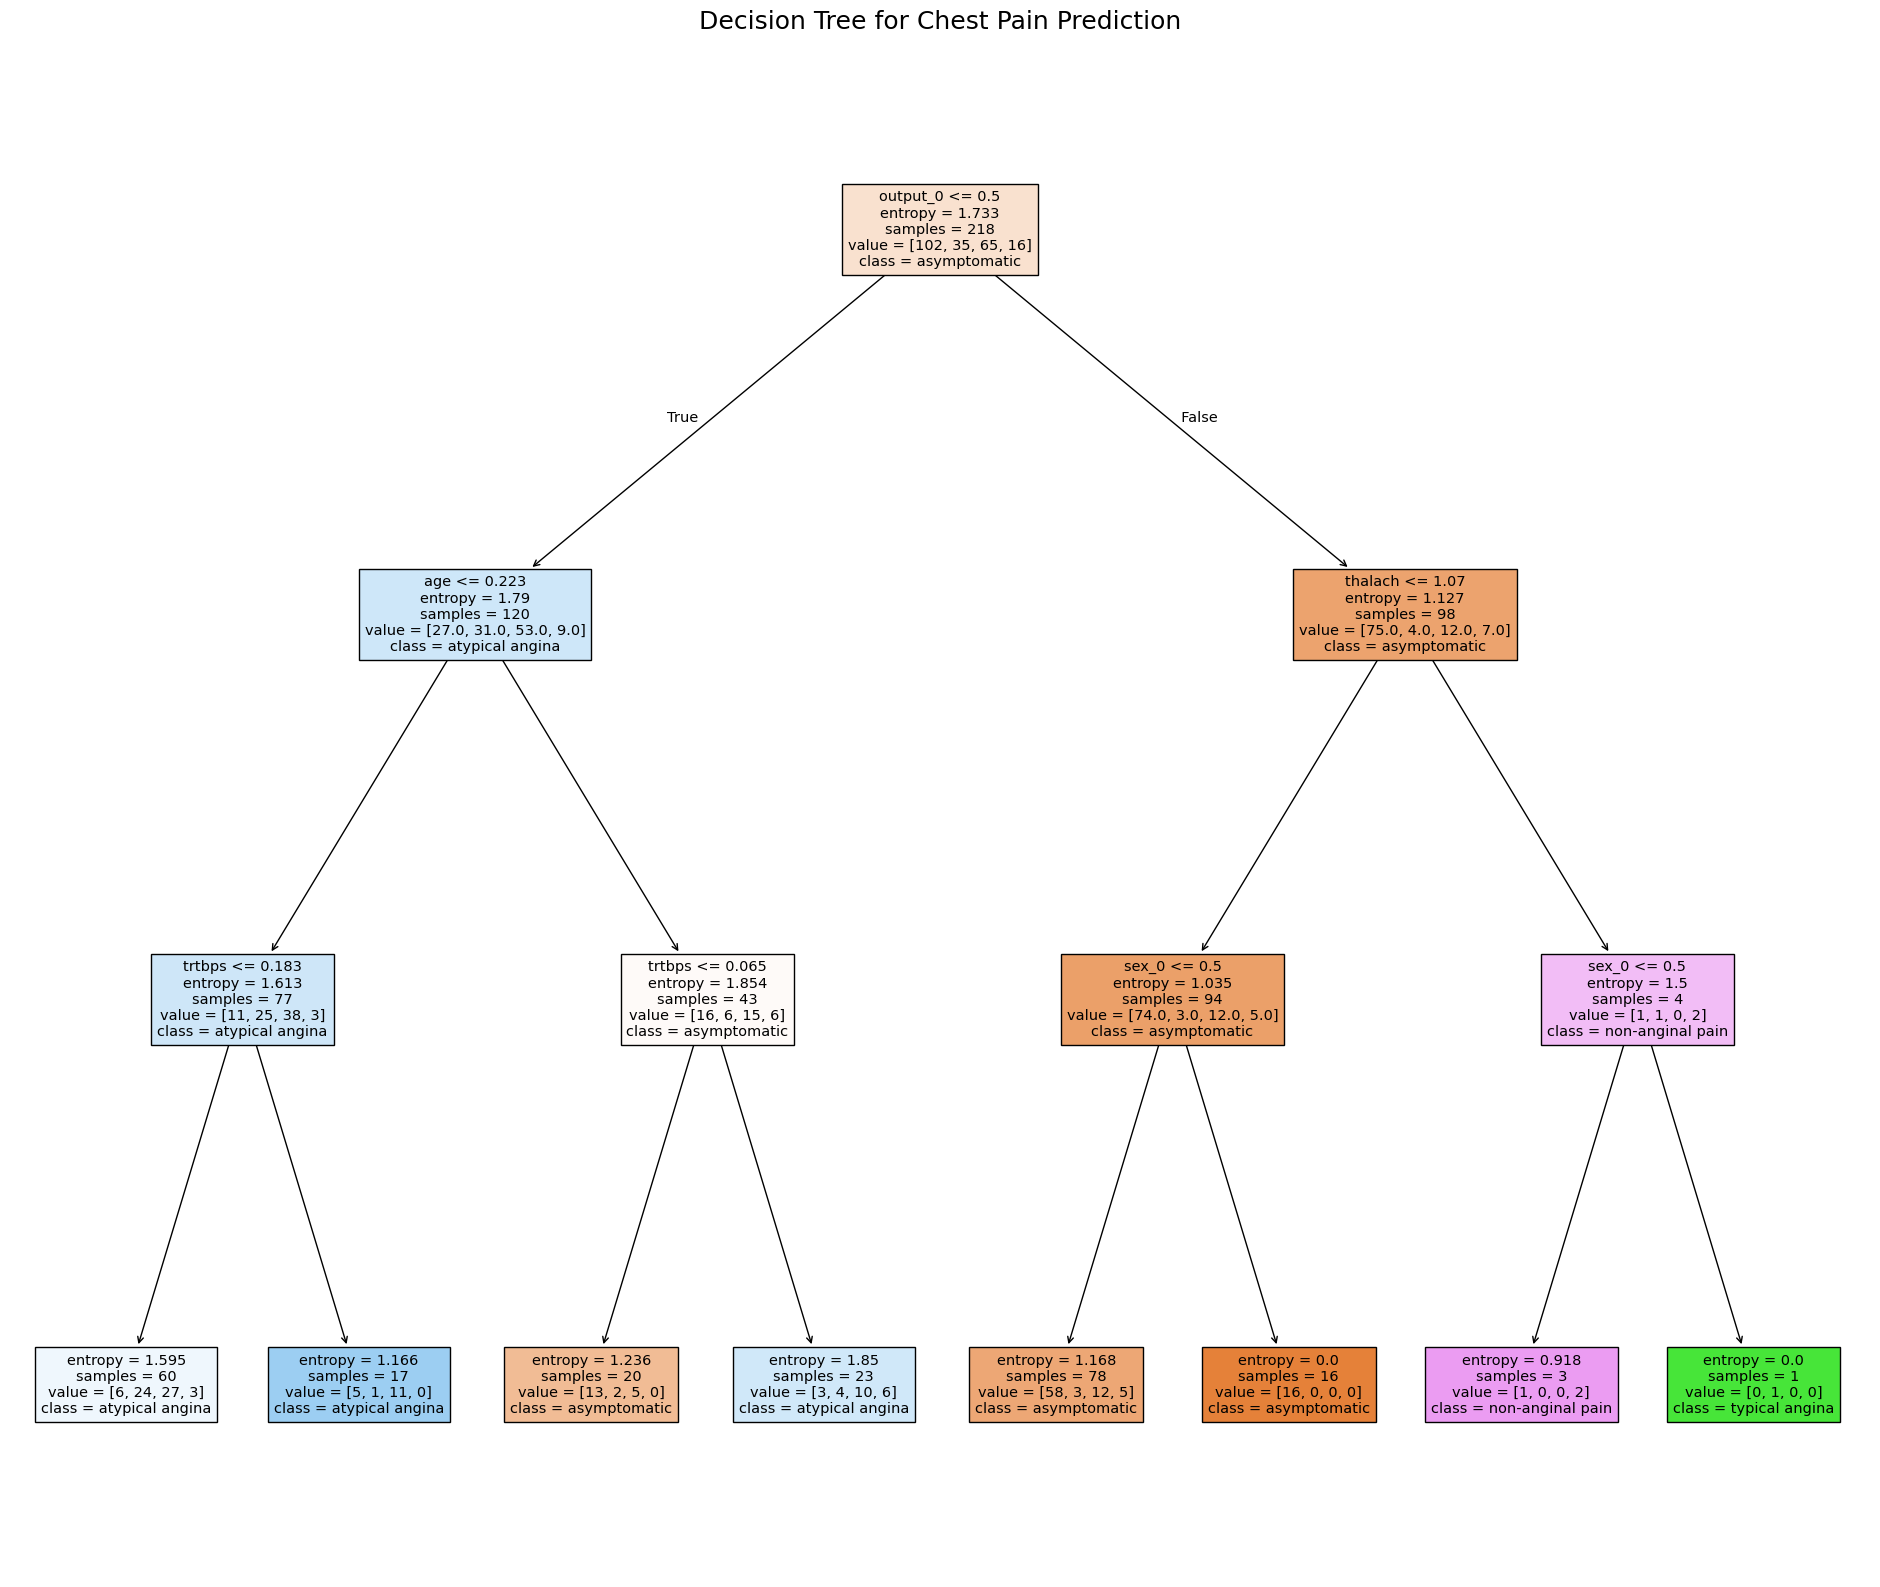

In [75]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

preprocessor.fit(X_train)

numerical_features = numerical_cols
categorical_features = preprocessor.named_transformers_["cat"].get_feature_names_out()
feature_names = list(numerical_features) + list(categorical_features)

dt_model = results["DecisionTree"]["best_params"]
dtree = pipelines["DecisionTree"].set_params(**dt_model).fit(X_train, y_train).named_steps["classifier"]

plt.figure(figsize=(24, 20))
plot_tree(dtree,
          feature_names=feature_names,
          class_names=["asymptomatic", "typical angina", "atypical angina", "non-anginal pain"],
          filled=True)
plt.title("Decision Tree for Chest Pain Prediction", fontsize=18)   

## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import pandas as pd

In [78]:
categories = ha["cp"].unique()  
f1_scores = {}

for category in categories:
    ha[f"cp_is_{category}"] = (ha["cp"] == category).astype(int)

    X = ha.drop(columns=["cp", f"cp_is_{category}"]) 
    y = ha[f"cp_is_{category}"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    f1 = f1_score(y_test, y_pred)
    f1_scores[category] = f1  

    print(f"Category {category}: F1 Score = {f1:.4f}")

best_category = max(f1_scores, key=f1_scores.get)
print("\nBest Distinguished Category:")
print(f"Category {best_category} with F1 Score = {f1_scores[best_category]:.4f}")

Category 3: F1 Score = 0.0000
Category 2: F1 Score = 0.2400
Category 1: F1 Score = 0.6154
Category 0: F1 Score = 1.0000

Best Distinguished Category:
Category 0 with F1 Score = 1.0000


### The best distinguished category is Category 0, which achieves a perfect F1 score of 1. This suggests that the classifier can easily distinguish category 0 from the others in pairwise comparisons. However, category 3 is poorly distinguished in OvO.

## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import pandas as pd

categories = ha["cp"].unique() 
f1_scores = {}

for category in categories:
    ha[f"cp_is_{category}"] = (ha["cp"] == category).astype(int)

    X = ha.drop(columns=["cp", f"cp_is_{category}"])  
    y = ha[f"cp_is_{category}"] 

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    f1 = f1_score(y_test, y_pred)
    f1_scores[category] = f1  

    print(f"Category {category}: F1 Score = {f1:.4f}")

best_category = max(f1_scores, key=f1_scores.get)
print("\nBest Distinguished Category:")
print(f"Category {best_category} with F1 Score = {f1_scores[best_category]:.4f}")

Category 3: F1 Score = 0.6667
Category 2: F1 Score = 1.0000
Category 1: F1 Score = 1.0000
Category 0: F1 Score = 1.0000

Best Distinguished Category:
Category 2 with F1 Score = 1.0000


### The best distinguished category is Category 2, with an F1 score of 1, indicating that the classifier performs very well when distinguishing category 2 from all other categories. Categories 1 and 0 are also perfectly distinguished in this approach, but category 3 shows a moderate performance with a score of 0.6667.